# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

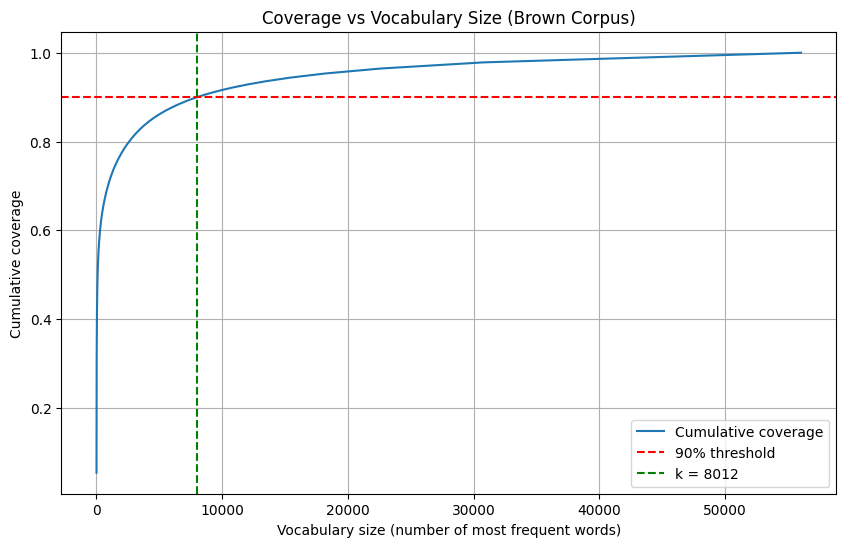

Minimum vocabulary size to cover at least 90% of words: 8012


In [1]:
import nltk
import matplotlib.pyplot as plt
from collections import Counter

# Download Brown corpus if not already present
nltk.download('brown', quiet=True)
from nltk.corpus import brown

# Load all words from the corpus
words = brown.words()

# Count word frequencies
freq = Counter(words)

# Sort words by frequency descending
sorted_freq = freq.most_common()

# Total number of word occurrences
total_occurrences = sum(freq.values())

# Compute cumulative coverage for each vocabulary size
cumulative = []
cum_sum = 0
for rank, (_, count) in enumerate(sorted_freq, start=1):
    cum_sum += count
    coverage = cum_sum / total_occurrences
    cumulative.append((rank, coverage))

# Find the smallest vocabulary size with coverage >= 0.9
vocab_size_90 = next(rank for rank, cov in cumulative if cov >= 0.9)

# Plot cumulative coverage vs vocabulary size
ranks, coverages = zip(*cumulative)
plt.figure(figsize=(10, 6))
plt.plot(ranks, coverages, label='Cumulative coverage')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.axvline(x=vocab_size_90, color='g', linestyle='--', label=f'k = {vocab_size_90}')
plt.xlabel('Vocabulary size (number of most frequent words)')
plt.ylabel('Cumulative coverage')
plt.title('Coverage vs Vocabulary Size (Brown Corpus)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Minimum vocabulary size to cover at least 90% of words: {vocab_size_90}")

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [ ]:
from collections import defaultdict, Counter
import re

class BPETokenizer:
    """
    Byte-Pair Encoding tokenizer.
    
    Attributes:
        vocab (set): Set of all tokens (strings) learned during training.
        merges (list): List of tuples (left, right) representing merge operations in order.
        end_token (str): Special token appended to each word to mark word boundary.
    """
    
    def __init__(self):
        self.vocab = set()
        self.merges = []
        self.end_token = '</w>'
    
    def train(self, corpus, num_merges):
        """
        Train BPE tokenizer on the given corpus.

        Args:
            corpus (iterable of str): Text corpus, each element is a sentence/document.
            num_merges (int): Number of merge operations to perform.
        """
        # 1. Build initial word frequency dictionary
        word_freq = Counter()
        for line in corpus:
            words = line.strip().split()
            for word in words:
                word_freq[word] += 1
        
        # 2. Represent each word as a list of characters plus end token
        word_splits = {}
        for word in word_freq:
            # Initial split: characters + end token
            word_splits[word] = list(word) + [self.end_token]
        
        # 3. Build initial vocabulary: all characters and end token
        for word in word_splits:
            for char in word_splits[word]:
                self.vocab.add(char)
        
        # 4. Perform merges
        for _ in range(num_merges):
            # Count all adjacent pairs across all words (with frequencies)
            pair_counts = defaultdict(int)
            for word, freq in word_freq.items():
                split = word_splits[word]
                for i in range(len(split) - 1):
                    pair = (split[i], split[i+1])
                    pair_counts[pair] += freq
            
            if not pair_counts:
                break  # No more pairs to merge
            
            # Find the most frequent pair
            best_pair = max(pair_counts, key=pair_counts.get)
            
            # Add merged token to vocabulary
            merged_token = best_pair[0] + best_pair[1]
            self.vocab.add(merged_token)
            
            # Record merge operation
            self.merges.append(best_pair)
            
            # Apply merge to all word splits
            new_word_splits = {}
            left, right = best_pair
            for word, split in word_splits.items():
                new_split = []
                i = 0
                while i < len(split):
                    if i < len(split) - 1 and split[i] == left and split[i+1] == right:
                        new_split.append(merged_token)
                        i += 2
                    else:
                        new_split.append(split[i])
                        i += 1
                new_word_splits[word] = new_split
            word_splits = new_word_splits
    
    def tokenize(self, text):
        """
        Tokenize input text using learned BPE merges.

        Args:
            text (str): Raw text to tokenize.

        Returns:
            list of str: List of tokens (subwords) covering the input.
        """
        # Split text into words (simple whitespace tokenization)
        words = text.strip().split()
        
        all_tokens = []
        for word in words:
            # Start with character-level split plus end token
            tokens = list(word) + [self.end_token]
            
            # Apply all merges in the order they were learned
            for left, right in self.merges:
                merged = left + right
                new_tokens = []
                i = 0
                while i < len(tokens):
                    if i < len(tokens) - 1 and tokens[i] == left and tokens[i+1] == right:
                        new_tokens.append(merged)
                        i += 2
                    else:
                        new_tokens.append(tokens[i])
                        i += 1
                tokens = new_tokens
            
            # Remove end token for final output (optional)
            # Here we keep it as part of the token; common practice is to keep it
            all_tokens.extend(tokens)
        
        return all_tokens

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [3]:
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Download Brown corpus if not already present
nltk.download('brown', quiet=True)
from nltk.corpus import brown


class BPETokenizer:
    """
    Byte-Pair Encoding tokenizer.
    
    Attributes:
        vocab (set): Set of all tokens (strings) learned during training.
        merges (list): List of tuples (left, right) representing merge operations in order.
        end_token (str): Special token appended to each word to mark word boundary.
    """
    
    def __init__(self):
        self.vocab = set()
        self.merges = []
        self.end_token = '</w>'
    
    def train(self, corpus, num_merges):
        """
        Train BPE tokenizer on the given corpus.

        Args:
            corpus (iterable of str): Text corpus, each element is a sentence/document.
            num_merges (int): Number of merge operations to perform.
        """
        # Build initial word frequency dictionary
        word_freq = Counter()
        for line in corpus:
            words = line.strip().split()
            for word in words:
                word_freq[word] += 1
        
        # Represent each word as a list of characters plus end token
        word_splits = {}
        for word in word_freq:
            word_splits[word] = list(word) + [self.end_token]
        
        # Build initial vocabulary: all characters and end token
        for word in word_splits:
            for char in word_splits[word]:
                self.vocab.add(char)
        
        # Perform merges
        for _ in range(num_merges):
            # Count all adjacent pairs across all words (with frequencies)
            pair_counts = Counter()
            for word, freq in word_freq.items():
                split = word_splits[word]
                for i in range(len(split) - 1):
                    pair = (split[i], split[i+1])
                    pair_counts[pair] += freq
            
            if not pair_counts:
                break
            
            # Find the most frequent pair
            best_pair = max(pair_counts, key=pair_counts.get)
            
            # Add merged token to vocabulary
            merged_token = best_pair[0] + best_pair[1]
            self.vocab.add(merged_token)
            
            # Record merge operation
            self.merges.append(best_pair)
            
            # Apply merge to all word splits
            left, right = best_pair
            new_word_splits = {}
            for word, split in word_splits.items():
                new_split = []
                i = 0
                while i < len(split):
                    if i < len(split) - 1 and split[i] == left and split[i+1] == right:
                        new_split.append(merged_token)
                        i += 2
                    else:
                        new_split.append(split[i])
                        i += 1
                new_word_splits[word] = new_split
            word_splits = new_word_splits
    
    def tokenize(self, text):
        """
        Tokenize input text using learned BPE merges.

        Args:
            text (str): Raw text to tokenize.

        Returns:
            list of str: List of tokens (subwords) covering the input.
        """
        words = text.strip().split()
        all_tokens = []
        for word in words:
            tokens = list(word) + [self.end_token]
            for left, right in self.merges:
                merged = left + right
                new_tokens = []
                i = 0
                while i < len(tokens):
                    if i < len(tokens) - 1 and tokens[i] == left and tokens[i+1] == right:
                        new_tokens.append(merged)
                        i += 2
                    else:
                        new_tokens.append(tokens[i])
                        i += 1
                tokens = new_tokens
            all_tokens.extend(tokens)
        return all_tokens

# Prepare corpus for BPE training: list of sentences as strings
sentences = [' '.join(sent) for sent in brown.sents()]
print(f"Total sentences in Brown corpus: {len(sentences)}")

# Determine initial vocabulary size (unique characters + end token)
all_chars = set()
for sent in sentences:
    for word in sent.split():
        all_chars.update(word)
initial_vocab_size = len(all_chars) + 1  # +1 for end token
print(f"Initial vocabulary size (characters + </w>): {initial_vocab_size}")

# Target vocabulary size from Task 1
target_vocab_size = vocab_size_90

# Number of merges needed to reach target vocabulary size
num_merges = target_vocab_size - initial_vocab_size
print(f"Number of merges to perform: {num_merges}")

# Train BPE tokenizer
tokenizer = BPETokenizer()
tokenizer.train(sentences, num_merges)
print(f"Final vocabulary size: {len(tokenizer.vocab)}")

# ------------------- Compute fertility and tokenized sentence length on 1000 samples -------------------
# Take first 1000 sentences for analysis
sample_sentences = sentences[:1000]

fertilities = []
tokenized_lengths = []

for sent in sample_sentences:
    original_words = sent.split()
    num_words = len(original_words)
    tokens = tokenizer.tokenize(sent)
    num_tokens = len(tokens)
    tokenized_lengths.append(num_tokens)
    fertility = num_tokens / num_words if num_words > 0 else 0
    fertilities.append(fertility)

mean_fertility = np.mean(fertilities)
std_fertility = np.std(fertilities)
mean_length = np.mean(tokenized_lengths)
std_length = np.std(tokenized_lengths)

print("\n--- Results on 1000 sentences ---")
print(f"Fertility (tokens per word): mean = {mean_fertility:.4f}, std = {std_fertility:.4f}")
print(f"Tokenized sentence length: mean = {mean_length:.2f}, std = {std_length:.2f}")

Total sentences in Brown corpus: 57340
Initial vocabulary size (characters + </w>): 84
Number of merges to perform: 7928
Final vocabulary size: 8012

--- Results on 1000 sentences ---
Fertility (tokens per word): mean = 1.3165, std = 0.3060
Tokenized sentence length: mean = 27.91, std = 15.39


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.